In [99]:
# 3. Import libraries and modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(123)  # for reproducibility
import os
import matplotlib
from PIL import Image

import keras
print keras.__version__

from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
import theano
import scipy as sp
from matplotlib import gridspec
from sklearn.decomposition import PCA
from numpy import genfromtxt
from random import shuffle

1.0.8


In [114]:
dir_path='saeam_data2/'

for root, dirs, files in os.walk(dir_path, topdown=True):
    for name in files: # loop through all the files in data/
        if name[0] != '.':
            print name

picking_xy_125_02.dat
picking_xy_128_92.dat
picking_xy_123_53.dat
picking_xy_126_82.dat
picking_xy_135_44.dat
picking_xy_126_22.dat
picking_xy_135_14.dat
#131_2_avg.dat
picking_xy_128_52.dat
picking_xy_130_24.dat
picking_xy_126_72.dat
picking_xy_125_22.dat
#130_4_avg.dat
picking_xy_126_32.dat
picking_xy_125_42.dat
picking_xy_129_54.dat
#125_2_avg.dat
picking_xy_133_42.dat
picking_xy_134_32.dat
picking_xy_131_42.dat
picking_xy_130_14.dat
picking_xy_129_84.dat
picking_xy_134_22.dat
picking_xy_123_73.dat
picking_xy_126_12.dat
picking_xy_129_04.dat
picking_xy_128_82.dat
picking_xy_128_12.dat
picking_xy_127_03.dat
picking_xy_133_22.dat
picking_xy_129_24.dat
picking_xy_125_12.dat
picking_xy_125_92.dat
picking_xy_123_13.dat
picking_xy_127_53.dat
#133_2_avg.dat
picking_xy_131_32.dat
picking_xy_129_94.dat
picking_xy_127_83.dat
picking_xy_132_02.dat
picking_xy_130_44.dat
picking_xy_126_62.dat
picking_xy_127_63.dat
picking_xy_135_34.dat
picking_xy_123_43.dat
picking_xy_128_02.dat
picking_xy_123_2

In [115]:
graph_data = dict()

for root, dirs, files in os.walk(dir_path, topdown=False):
    for name in files: # loop through all the files in data/
        if "#" in name and name[0] != '.':
            my_data = np.log10(genfromtxt(os.path.join(root, name), delimiter=','))[1:,] # cut off the 1st row 0 value
            graph_data[name] = my_data

In [116]:
graph_data

{'#123_3_avg.dat': array([[-3.80740467,  2.0213788 ],
        [-3.50636074,  2.02308911],
        [-3.33027413,  2.00186789],
        ..., 
        [-0.80098496,  1.86380506],
        [-0.80055741,  1.82086481],
        [-0.80013029,  1.78449613]]),
 '#125_2_avg.dat': array([[-3.80740467,  2.0371704 ],
        [-3.50636074,  2.00675267],
        [-3.33027413,  1.9985348 ],
        ..., 
        [-0.80098496,  1.85958673],
        [-0.80055741,  1.81594384],
        [-0.80013029,  1.77948898]]),
 '#127_3_avg.dat': array([[-3.80740467,  1.98387178],
        [-3.50636074,  1.96601594],
        [-3.33027413,  1.94478909],
        ..., 
        [-0.80098496,  1.86019335],
        [-0.80055741,  1.81665663],
        [-0.80013029,  1.78060159]]),
 '#128_2_avg.dat': array([[-3.80740467,  1.93756468],
        [-3.50636074,  1.92784213],
        [-3.33027413,  1.92676381],
        ..., 
        [-0.80098496,  1.8296618 ],
        [-0.80055741,  1.78623107],
        [-0.80013029,  1.75056893]]),


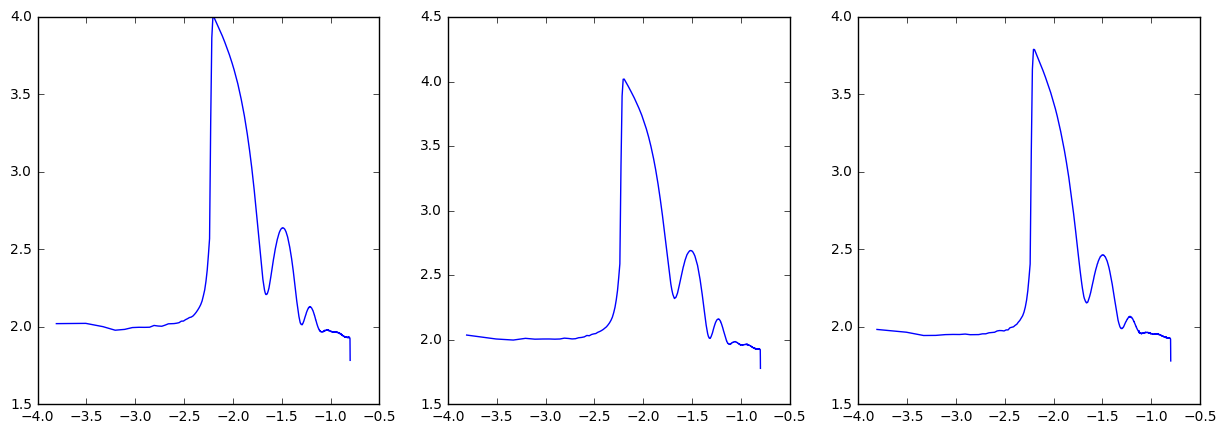

In [117]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
axes.flat[0].plot(graph_data['#123_3_avg.dat'][:,0], graph_data['#123_3_avg.dat'][:,1])
axes.flat[1].plot(graph_data['#125_2_avg.dat'][:,0], graph_data['#125_2_avg.dat'][:,1])
axes.flat[2].plot(graph_data['#127_3_avg.dat'][:,0], graph_data['#127_3_avg.dat'][:,1])
plt.show()

[[  2.19690000e-02   1.43230395e+02]
 [  4.89240000e-02   9.79064840e+01]
 [  7.83660000e-02   9.06353990e+01]
 [  1.01900000e-01   9.00079610e+01]]


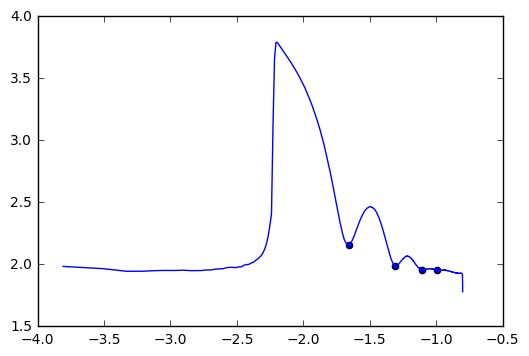

In [118]:
my_data = genfromtxt(os.path.join(root, 'picking_xy_127_03.dat'), delimiter='\t')
print my_data
plt.plot(graph_data['#127_3_avg.dat'][:,0], graph_data['#127_3_avg.dat'][:,1])
plt.scatter(np.log10(my_data[:,0]), np.log10(my_data[:,1]))

In [119]:
graph_data['#123_3_avg.dat'].shape

(1017, 2)

In [77]:
graph_data['#123_3_avg.dat']

array([[-3.80740467,  2.0213788 ],
       [-3.50636074,  2.02308911],
       [-3.33027413,  2.00186789],
       ..., 
       [-0.80098496,  1.86380506],
       [-0.80055741,  1.82086481],
       [-0.80013029,  1.78449613]])

In [70]:
sum(graph_data['#123_3_avg.dat'] == np.nan)

array([0, 0])

In [120]:
X_data = []
y_data = []
label_order = []
for k,v in graph_data.items():
    graph_number = k[1:k.find('_')] # like 127..
    
    # though it's brute force way..
    # We'll walk through all, once for each different graph
    for root, dirs, files in os.walk(dir_path, topdown=False):
        for name in files: # loop through all the files in data/
            if "picking_xy_"+graph_number in name and name[0] != '.':
                points = np.log10(genfromtxt(os.path.join(root, name), delimiter='\t'))
                flattened_graph = np.hstack((graph_data[k][:,0],graph_data[k][:,1]))
                #print flattened_graph.shape
                #X_data.append(graph_data[k]) # append graph
                X_data.append(flattened_graph)
                flattened_points = np.hstack((points[:,0],points[:,1]))
                y_data.append(flattened_points)
                label_order.append(k)

    
X = np.asarray(X_data)
y = np.asarray(y_data)
print X.shape, y.shape

(80, 2034) (80, 8)


In [121]:
label_order

['#129_4_avg.dat',
 '#129_4_avg.dat',
 '#129_4_avg.dat',
 '#129_4_avg.dat',
 '#129_4_avg.dat',
 '#129_4_avg.dat',
 '#129_4_avg.dat',
 '#129_4_avg.dat',
 '#129_4_avg.dat',
 '#129_4_avg.dat',
 '#131_2_avg.dat',
 '#131_2_avg.dat',
 '#131_2_avg.dat',
 '#131_2_avg.dat',
 '#131_2_avg.dat',
 '#130_4_avg.dat',
 '#130_4_avg.dat',
 '#130_4_avg.dat',
 '#130_4_avg.dat',
 '#130_4_avg.dat',
 '#128_2_avg.dat',
 '#128_2_avg.dat',
 '#128_2_avg.dat',
 '#128_2_avg.dat',
 '#128_2_avg.dat',
 '#128_2_avg.dat',
 '#128_2_avg.dat',
 '#128_2_avg.dat',
 '#128_2_avg.dat',
 '#128_2_avg.dat',
 '#127_3_avg.dat',
 '#127_3_avg.dat',
 '#127_3_avg.dat',
 '#127_3_avg.dat',
 '#127_3_avg.dat',
 '#127_3_avg.dat',
 '#127_3_avg.dat',
 '#127_3_avg.dat',
 '#127_3_avg.dat',
 '#127_3_avg.dat',
 '#125_2_avg.dat',
 '#125_2_avg.dat',
 '#125_2_avg.dat',
 '#125_2_avg.dat',
 '#125_2_avg.dat',
 '#125_2_avg.dat',
 '#125_2_avg.dat',
 '#125_2_avg.dat',
 '#125_2_avg.dat',
 '#125_2_avg.dat',
 '#133_2_avg.dat',
 '#133_2_avg.dat',
 '#133_2_avg

In [124]:
label_order[74:]

['#134_2_avg.dat',
 '#135_4_avg.dat',
 '#135_4_avg.dat',
 '#135_4_avg.dat',
 '#135_4_avg.dat',
 '#135_4_avg.dat']

In [125]:
train_split = 75
X_train = X[:train_split,]
y_train = y[:train_split,]
X_test = X[train_split:,]
y_test = y[train_split:,]
print X_train.shape, y_train.shape, X_test.shape, y_test.shape

(75, 2034) (75, 8) (5, 2034) (5, 8)


In [126]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(100, input_dim=2034))
model.add(Activation('relu'))
model.add(Dense(8))

model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_26 (Dense)                 (None, 100)           203500      dense_input_15[0][0]             
____________________________________________________________________________________________________
activation_10 (Activation)       (None, 100)           0           dense_26[0][0]                   
____________________________________________________________________________________________________
dense_27 (Dense)                 (None, 8)             808         activation_10[0][0]              
Total params: 204308
____________________________________________________________________________________________________


In [127]:
sgd = SGD(lr='0.01', momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])
model.fit(X_train, y_train, nb_epoch=100, validation_data=(X_test, y_test))

Train on 75 samples, validate on 5 samples
Epoch 1/100
75/75 [==============================] - 0s - loss: 694.8891 - acc: 0.0000e+00 - val_loss: 2.9978 - val_acc: 0.0000e+00
Epoch 2/100
75/75 [==============================] - 0s - loss: 2.7697 - acc: 0.0000e+00 - val_loss: 2.7329 - val_acc: 0.0000e+00
Epoch 3/100
75/75 [==============================] - 0s - loss: 2.5160 - acc: 0.0000e+00 - val_loss: 2.4807 - val_acc: 0.0000e+00
Epoch 4/100
75/75 [==============================] - 0s - loss: 2.2733 - acc: 0.0000e+00 - val_loss: 2.2328 - val_acc: 0.0000e+00
Epoch 5/100
75/75 [==============================] - 0s - loss: 2.0352 - acc: 0.0000e+00 - val_loss: 1.9900 - val_acc: 0.0000e+00
Epoch 6/100
75/75 [==============================] - 0s - loss: 1.8034 - acc: 0.0000e+00 - val_loss: 1.7560 - val_acc: 0.0000e+00
Epoch 7/100
75/75 [==============================] - 0s - loss: 1.5816 - acc: 0.0000e+00 - val_loss: 1.5352 - val_acc: 0.0000e+00
Epoch 8/100
75/75 [==========================

In [128]:
y_pred = model.predict(X_test)
print y_pred.shape

(5, 8)


In [129]:
print y_pred[0,:4]
print y_pred[1,:4]
print y_pred[2,:4]
print y_test[0,:4]

[-1.65507472 -1.30549002 -1.10571694 -0.97290486]
[-1.65507472 -1.30549002 -1.10571694 -0.97290486]
[-1.65507472 -1.30549002 -1.10571694 -0.97290486]
[-1.68016552 -1.32879938 -1.1353169  -0.99585926]


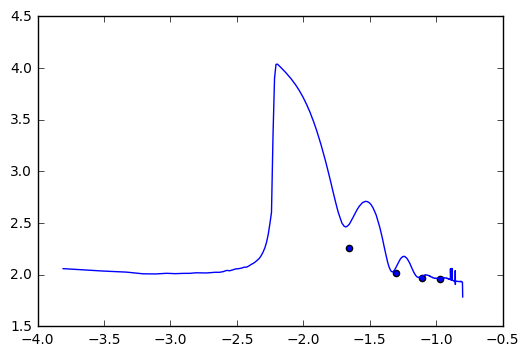

In [130]:
plt.plot(graph_data['#135_4_avg.dat'][:,0], graph_data['#135_4_avg.dat'][:,1])
plt.scatter(y_pred[0,:4], y_pred[0,4:])

In [132]:
graph_data.keys(), len(graph_data.keys())

(['#129_4_avg.dat',
  '#131_2_avg.dat',
  '#130_4_avg.dat',
  '#128_2_avg.dat',
  '#127_3_avg.dat',
  '#125_2_avg.dat',
  '#133_2_avg.dat',
  '#132_2_avg.dat',
  '#123_3_avg.dat',
  '#134_2_avg.dat',
  '#135_4_avg.dat'],
 11)

# 새암이언니, 이 코드만 보면 돼. 위에꺼는 다 연습용으로 해놓은거라 지저분

In [ ]:
# 3. Import libraries and modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(123)  # for reproducibility
import os
import matplotlib
from PIL import Image

import keras
print keras.__version__

from keras import backend as K
K.set_image_dim_ordering('tf')
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
import theano
import scipy as sp
from matplotlib import gridspec
from sklearn.decomposition import PCA
from numpy import genfromtxt
from random import shuffle

dir_path='saeam_data2/'


################################
# SAVE GRAPH DATA INTO DICT    #
################################
graph_data = dict()

for root, dirs, files in os.walk(dir_path, topdown=False):
    for name in files: # loop through all the files in data/
        if "#" in name and name[0] != '.':
            my_data = np.log10(genfromtxt(os.path.join(root, name), delimiter=','))[1:,] # cut off the 1st row 0 value
            graph_data[name] = my_data
            

            
##################################
# READ XY_POINTS AND SAVE INTO X #
##################################
X_data = []
y_data = []
label_order = []
for k,v in graph_data.items():
    graph_number = k[1:k.find('_')] # like 127..
    
    # though it's brute force way..
    # We'll walk through all, once for each different graph
    for root, dirs, files in os.walk(dir_path, topdown=False):
        for name in files: # loop through all the files in data/
            if "picking_xy_"+graph_number in name and name[0] != '.':
                points = np.log10(genfromtxt(os.path.join(root, name), delimiter='\t'))
                flattened_graph = np.hstack((graph_data[k][:,0],graph_data[k][:,1]))
                #print flattened_graph.shape
                #X_data.append(graph_data[k]) # append graph
                X_data.append(flattened_graph)
                flattened_points = np.hstack((points[:,0],points[:,1]))
                y_data.append(flattened_points)
                label_order.append(k)

    
X = np.asarray(X_data)
y = np.asarray(y_data)


##################################
# SPLIT TRAIN & TEST DATA        #
##################################
train_split = 75
X_train = X[:train_split,]
y_train = y[:train_split,]
X_test = X[train_split:,]
y_test = y[train_split:,]
print X_train.shape, y_train.shape, X_test.shape, y_test.shape


##################################
# BUILD UP NEURAL NETWORK MODEL  #
##################################
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(100, input_dim=2034))
model.add(Activation('relu'))
model.add(Dense(8))

model.summary()


##########################
# TRAIN (FIT) THE MODEL  #
##########################
sgd = SGD(lr='0.01', momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['accuracy'])
model.fit(X_train, y_train, nb_epoch=100, validation_data=(X_test, y_test))